In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np

mg_color = '#00af2b'
h2o_color = '#df0303'
mg_light_color = '#b2e7bf'
h2o_light_color = '#f29a9a'

ticksize = 12
labelsize = 14
titlesize = 16
figsizeG = (6.5,3)
linewidth = 2
dpi = 400
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams['svg.fonttype'] = 'none'

consensus_criteria = 'both'
md_water_max_dist = 3.2
md_time_limit = 10 
md_allow_skip = 1 
md_rmsd_cutoff = 3.4 
md_mg_max_dist = 2.2


In [5]:
df = pd.read_csv("../water_consensus/all_solvent_consensus_status_withconsensus.csv")

# get group of consensus water and ion
if consensus_criteria == "both":
    wat = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH") & (df["consensus of wat in 2.3Å"])]
    mg = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG") & (df["consensus of mg in 2.3Å"])]
    #wat = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH") & ((df["exact binding spot of wat in 2.3Å"]>0) & (df["within 1A of wat in 2.3Å"]>0))]
    #mg = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG") & ((df["exact binding spot of mg in 2.3Å"]>0) & (df["within 1A of mg in 2.3Å"]>0))]
elif consensus_criteria == "binding_site":
    wat = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH") & (df["exact binding spot of wat in 2.3Å"]>0)]
    mg = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG") & (df["exact binding spot of mg in 2.3Å"]>0)]
elif consensus_criteria == "1A":
    wat = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH") & (df["within 1A of wat in 2.3Å"]>0)]
    mg = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG") & (df["within 1A of mg in 2.3Å"]>0)]
elif consensus_criteria == "either":
    wat = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH") & ((df["exact binding spot of wat in 2.3Å"]>0) | (df["within 1A of wat in 2.3Å"]>0))]
    mg = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG") & ((df["exact binding spot of mg in 2.3Å"]>0) | (df["within 1A of mg in 2.3Å"]>0))]

# get water and ions from each structure
mg22 = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG")]
mg23 = df[(df.model.astype(str)=="2.3Å") & (df.solvent=="MG")]
wat22 = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH")]
wat23 = df[(df.model.astype(str)=="2.3Å") & (df.solvent=="HOH")]
mgp4p6 = df[(df.model.astype(str).isin(["1hr2_A","1hr2_B","1gid_A","1gid_B"])) & (df.solvent=="MG")]
watp4p6 = df[(df.model.astype(str).isin(["1hr2_A","1hr2_B","1gid_A","1gid_B"])) & (df.solvent=="HOH")]

# count for each group
mg_cryoem_sites = mg['binding_site'].str.split().explode()
mg_cryoem_counts = mg_cryoem_sites.apply(lambda x: (x.split('-')[0],x.split(':')[1])).value_counts()
wat_cryoem_sites = wat[wat.binding_site==wat.binding_site]['binding_site'].str.split().explode()
wat_cryoem_counts = wat_cryoem_sites.apply(lambda x: (x.split('-')[0],x.split(':')[1])).value_counts()
mg_cryoem_sites = mg22['binding_site'].str.split().explode()
mg_cryoem22_counts = mg_cryoem_sites.apply(lambda x: (x.split('-')[0],x.split(':')[1])).value_counts()
wat_cryoem_sites = wat22[wat22.binding_site==wat22.binding_site]['binding_site'].str.split().explode()
wat_cryoem22_counts = wat_cryoem_sites.apply(lambda x: (x.split('-')[0],x.split(':')[1])).value_counts()
mg_cryoem_sites = mg23['binding_site'].str.split().explode()
mg_cryoem23_counts = mg_cryoem_sites.apply(lambda x: (x.split('-')[0],x.split(':')[1])).value_counts()
wat_cryoem_sites = wat23[wat23.binding_site==wat23.binding_site]['binding_site'].str.split().explode()
wat_cryoem23_counts = wat_cryoem_sites.apply(lambda x: (x.split('-')[0],x.split(':')[1])).value_counts()
mg_p4p46_sites = mgp4p6['binding_site'].str.split().explode()
mg_p4p6_counts = mg_p4p46_sites[mg_p4p46_sites==mg_p4p46_sites].apply(lambda x: (x.split('-')[0],x.split(':')[1])).value_counts()
wat_p4p6_sites = watp4p6[watp4p6.binding_site==watp4p6.binding_site]['binding_site'].str.split().explode()
wat_p4p6_counts = wat_p4p6_sites.apply(lambda x: (x.split('-')[0],x.split(':')[1])).value_counts()

# likewise count sites for MD simulation
md_sites_wat = pd.read_csv(f'../water_consensus/wat_md_dist{md_water_max_dist}_time{md_time_limit}_skip{md_allow_skip}_rmsdcut{md_rmsd_cutoff}.csv')
md_sites_wat['binding_site'] = md_sites_wat['RNA_atoms'].str.split()
md_sites_wat = md_sites_wat[['binding_site','avg_time']]
md_sites_wat = md_sites_wat.explode(column='binding_site')
md_sites_wat['binding_site'] = md_sites_wat['binding_site'].apply(lambda x: (x.split('-')[0],x.split(':')[1]))
md_sites_wat_t = md_sites_wat.groupby('binding_site').avg_time.sum()
md_sites_wat_bind = md_sites_wat.binding_site.value_counts()

md_sites_mg = pd.read_csv(f'../water_consensus/Mg_md_dist{md_mg_max_dist}_time{md_time_limit}_skip{md_allow_skip}_rmsdcut{md_rmsd_cutoff}.csv')
md_sites_mg['binding_site'] = md_sites_mg['RNA_atoms'].str.split()
md_sites_mg = md_sites_mg[['binding_site','avg_time']]
md_sites_mg = md_sites_mg.explode(column='binding_site')
md_sites_mg['binding_site'] = md_sites_mg['binding_site'].apply(lambda x: (x.split('-')[0],x.split(':')[1]))
md_sites_mg_t = md_sites_mg.groupby('binding_site').avg_time.sum()
md_sites_mg_bind = md_sites_mg.binding_site.value_counts()

# for Mg PDB manually took counts from website
total_mg_rna_inner = 5585
mgrna_inner = {"3•OP":823,"2•OP":2002,"OP":588,"Or":22,"Ob":468,"Nb":284}

In [6]:
mg_rna_perc = [100*238/5585]*15 +  [100*468/5585]*4+ [100*(823+2002+588)/5585]*4+ [100*22/5585]*16
mg_rna_count = ['']*7 + [238] + ['']*7 + ['']*2+ [468] +['']+ ['']*2+ [823+2002+588] +['']+ ['']*8+ [823+2002+588] +['']*7

In [7]:
atoms = ['N1','N3','N1','N1','N9','N9','N2','N4','N6','N3','N3','N1','N3','N7','N7',
        'O6','O4','O2','O2','OP','OP','OP','OP',
        "O5'","O5'","O5'","O5'","O3'","O3'","O3'","O3'",
        "O4'","O4'","O4'","O4'","O2'","O2'","O2'","O2'"]
bases = ['G','U','C','U','G','A','G','C','A','G','A','A','C','G','A',
        'G','U','C','U','G','A','C','U',
        'G','A','C','U','G','A','C','U',
        'G','A','C','U','G','A','C','U']
mg_md_t_total = md_sites_mg_t.sum()
mg_md_bind_total = md_sites_mg_bind.sum()
mg_cryoem_total = mg_cryoem_counts.sum()
wat_md_t_total = md_sites_wat_t.sum()
wat_md_bind_total = md_sites_wat_bind.sum()
wat_cryoem_total = wat_cryoem_counts.sum()
count_data = {'Mg2+ cryo-EM':[],'Mg2+ cryo-EM 2.2':[],'Mg2+ cryo-EM 2.3':[],'Mg2+ MD':[],'Mg2+ MD time':[],'Mg2+ P4P6':[],'H2O P4P6':[],'H2O cryo-EM':[],'H2O cryo-EM 2.2':[],'H2O cryo-EM 2.3':[],'H2O MD':[],'H2O MD time':[]}
perc_data = {'Mg2+ cryo-EM':[],'Mg2+ cryo-EM 2.2':[],'Mg2+ cryo-EM 2.3':[],'Mg2+ MD':[],'Mg2+ MD time':[],'Mg2+ P4P6':[],'H2O P4P6':[],'H2O cryo-EM':[],'H2O cryo-EM 2.2':[],'H2O cryo-EM 2.3':[],'H2O MD':[],'H2O MD time':[]}
total_dict = {'Mg2+ cryo-EM':mg_cryoem_counts.sum(),'Mg2+ cryo-EM 2.2':mg_cryoem22_counts.sum(),'Mg2+ cryo-EM 2.3':mg_cryoem23_counts.sum(),'Mg2+ MD':md_sites_mg_bind.sum(),
              'Mg2+ MD time':md_sites_mg_t.sum(),'Mg2+ P4P6':mg_p4p6_counts.sum(),'H2O P4P6':wat_p4p6_counts.sum(),
              'H2O cryo-EM':wat_cryoem_counts.sum(),'H2O cryo-EM 2.2':wat_cryoem22_counts.sum(),'H2O cryo-EM 2.3':wat_cryoem23_counts.sum(),
              'H2O MD':md_sites_wat_bind.sum(),'H2O MD time':md_sites_wat_t.sum()}
df_dict = {'Mg2+ cryo-EM':mg_cryoem_counts,'Mg2+ cryo-EM 2.2':mg_cryoem22_counts,'Mg2+ cryo-EM 2.3':mg_cryoem23_counts,'Mg2+ MD':md_sites_mg_bind,'Mg2+ MD time':md_sites_mg_t,
              'H2O cryo-EM':wat_cryoem_counts,'H2O cryo-EM 2.2':wat_cryoem22_counts,'H2O cryo-EM 2.3':wat_cryoem23_counts,
           'H2O MD':md_sites_wat_bind,'H2O MD time':md_sites_wat_t,'Mg2+ P4P6':mg_p4p6_counts,'H2O P4P6':wat_p4p6_counts}

# for each atom go through and count
for atom,base in zip(atoms,bases):
    for data in df_dict:
        if (base,atom) in df_dict[data]:
            count = df_dict[data][(base,atom)]
        else:
            count = 0
        count_data[data].append(count)
        perc_data[data].append(100*count/total_dict[data])

count_data['atom'] = atoms
count_data['base'] = bases
perc_data['atom'] = np.zeros(len(atoms))
perc_data['base'] = np.zeros(len(atoms))
count_data['Mg2+ PDB'] = mg_rna_count
perc_data['Mg2+ PDB'] = mg_rna_perc

In [8]:
count_data['H2O MD'] = [round(x,2) for x in count_data['H2O MD']]
count_data['Mg2+ MD'] = [round(x,2) for x in count_data['Mg2+ MD']]
count_data['H2O MD time'] = [round(x,2) for x in count_data['H2O MD time']]
count_data['Mg2+ MD time'] = [round(x,2) for x in count_data['Mg2+ MD time']]

cols = ['atom','base','Mg2+ cryo-EM','Mg2+ cryo-EM 2.2','Mg2+ cryo-EM 2.3','Mg2+ MD','Mg2+ MD time','Mg2+ P4P6','Mg2+ PDB',
        'H2O cryo-EM','H2O cryo-EM 2.2','H2O cryo-EM 2.3','H2O MD','H2O MD time','H2O P4P6']
df_count = pd.DataFrame(count_data)[cols]
perc_data = pd.DataFrame(perc_data)[cols]

/tmp/ipykernel_146856/2686070617.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([""]*len(cbar.ax.get_yticklabels()))


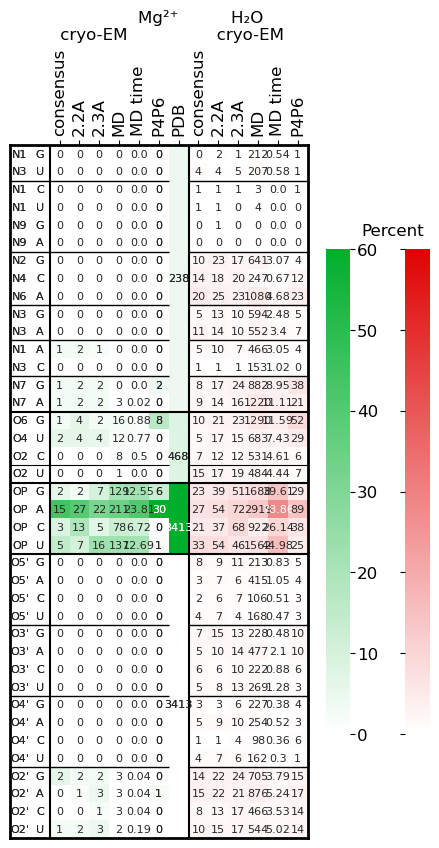

In [9]:
plt.figure(figsize=(6,9))
end = 15
middle = 8
lw = 1
perc_data_temp = perc_data.copy()
perc_data_temp[cols[2:7]] = np.nan
cmap = LinearSegmentedColormap.from_list("cmap", ["white",h2o_color])
g = sns.heatmap(perc_data_temp,annot=df_count, fmt = '',
            cmap=cmap,cbar_kws={'shrink':0.7},vmax=60,vmin=0,annot_kws={"size": 8})
perc_data_temp = perc_data.copy()
perc_data_temp[cols[middle+1:]] = np.nan

cmap = LinearSegmentedColormap.from_list("cmap", ["white",mg_color])
g = sns.heatmap(perc_data_temp,annot=df_count, fmt = '',
            cmap=cmap,cbar_kws={'shrink':0.7},vmax=60,vmin=0,annot_kws={"size": 8})


plt.hlines(18,0,middle,color='black',linewidth=lw*0.8)
plt.hlines(18,middle+1,end,color='black',linewidth=lw*0.8)
line_positions = [2,6,9,11,13,27,31,35]
for y in line_positions:
    plt.hlines(y,0,middle,color='black',linewidth=lw)
    plt.hlines(y,middle+1,end,color='black',linewidth=lw)
line_positions = [15,19,23]
for y in line_positions:
    plt.hlines(y,0,end,color='black',linewidth=lw*1.5)

plt.vlines(2,0,39,color='black',linewidth=lw*1.5)
plt.vlines(middle+1,0,39,color='black',linewidth=lw*1.5)


for _, spine in g.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(lw*2)

t=g.set_yticks([])

cbar = g.collections[0].colorbar
cbar.ax.set_yticklabels([""]*len(cbar.ax.get_yticklabels()))
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.set_title('Percent',size=ticksize,pad=10,loc="left",x=-1.8)

cbar = g.collections[1].colorbar
cbar.ax.tick_params(labelsize=ticksize,pad=1)

g.set_xticks([2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5],['consensus','2.2A','2.3A','MD','MD time','P4P6','PDB','consensus','2.2A','2.3A','MD','MD time','P4P6'])
g.tick_params(axis='x', labelsize=ticksize,rotation=90)
g.xaxis.tick_top()
t=g.set_title("                Mg²⁺          H₂O\n     cryo-EM                 cryo-EM")
plt.savefig("interaction_types_all.png",dpi=dpi, bbox_inches="tight",transparent=True)
plt.savefig("interaction_types_all.svg", bbox_inches="tight",transparent=True)

In [13]:
# get the consensus and the label to bidning site types, consensus is 2.2A consensus atoms
df = pd.read_csv("../water_consensus/all_solvent_consensus_status_withconsensus.csv")

if consensus_criteria == "both":
    matching_22_water = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH") & (df["consensus of wat in 2.3Å"])]
    matching_22_mg = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG") & (df["consensus of mg in 2.3Å"])]
    #matching_22_water = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH") & ((df["exact binding spot of wat in 2.3Å"]>0) & (df["within 1A of wat in 2.3Å"]>0))]
    #matching_22_mg = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG") & ((df["exact binding spot of mg in 2.3Å"]>0) & (df["within 1A of mg in 2.3Å"]>0))]
elif consensus_criteria == "binding_site":
    matching_22_water = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH") & (df["exact binding spot of wat in 2.3Å"]>0)]
    matching_22_mg = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG") & (df["exact binding spot of mg in 2.3Å"]>0)]
elif consensus_criteria == "1A":
    matching_22_water = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH") & (df["within 1A of wat in 2.3Å"]>0)]
    matching_22_mg = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG") & (df["within 1A of mg in 2.3Å"]>0)]
elif consensus_criteria == "either":
    matching_22_water = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH") & ((df["exact binding spot of wat in 2.3Å"]>0) | (df["within 1A of wat in 2.3Å"]>0))]
    matching_22_mg = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG") & ((df["exact binding spot of mg in 2.3Å"]>0) | (df["within 1A of mg in 2.3Å"]>0))]

mg22 = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="MG")]
mg23 = df[(df.model.astype(str)=="2.3Å") & (df.solvent=="MG")]
wat22 = df[(df.model.astype(str)=="2.2Å") & (df.solvent=="HOH")]
wat23 = df[(df.model.astype(str)=="2.3Å") & (df.solvent=="HOH")]
mgp4p6 = df[(df.model.astype(str).isin(["1hr2_A","1hr2_B","1gid_A","1gid_B"])) & (df.solvent=="MG")]
watp4p6 = df[(df.model.astype(str).isin(["1hr2_A","1hr2_B","1gid_A","1gid_B"])) & (df.solvent=="HOH")]

total_mg_rna_inner = 5585
mgrna_inner = {"3•OP":823,"2•OP":2002,"OP":588,"Or":22,"Ob":468,"Nb":284}

def convert_to_mgrna(atomstr,nonnum=False):
    OP,Ob,Or,Nb = 0,0,0,0
    for atom in atomstr.split("_"):
        if atom == "OP":
            OP += 1
        elif atom in ["O2'","O3'","O4'","O5'"]:
            Or += 1
        elif atom in ["O2","O4","O6"]:
            Ob += 1
        elif atom in ["N1","N7","N6","N4","N3","N2","N9"]:
            Nb += 1
        #elif "C" in atom:
        #    print(atomstr)
        #elif "P" in atom:
        #    print(atomstr)
        #else:
        #    print(atom)
    atom_string = ""
    if OP+Ob+Or+Nb==0:
        return("Near carbon or\nphosphorous only")
    if OP == 1 and not nonnum: atom_string += "OP "
    elif nonnum and OP>0: atom_string += "Phospate\n"
    elif OP>1 and not nonnum: atom_string += f"+2•OP "
    if Ob == 1 and not nonnum: atom_string += "Ob "
    elif (nonnum and Ob>0) or (nonnum and Nb>0): atom_string += "Base\n"
    elif Ob>1 and not nonnum: atom_string += f"{Ob}•Ob "
    if Or == 1 and not nonnum: atom_string += "Or "
    elif nonnum and Or>0: 
        if len(atom_string)>12:
            atom_string = atom_string[:-1]+ " Sugar\n"
        else:
            atom_string += "Sugar\n"
    elif Or>1 and not nonnum: atom_string += f"{Or}•Or "
    if Nb == 1 and not nonnum: atom_string += "Nb "
    elif Nb>1 and not nonnum: atom_string += f"{Nb}•Nb "
    return atom_string[:-1]


mgrna_inner = {"+2•OP":2825,"OP":588,"Or":22,"Ob":468,"Nb":284}

matching_22_mg = [convert_to_mgrna("_".join([atom.split(":")[-1] for atom in x.split()])) for x in matching_22_mg.binding_site.to_list()]
mg22 = [convert_to_mgrna("_".join([atom.split(":")[-1] for atom in x.split()])) for x in mg22.binding_site.to_list()]
mg23 = [convert_to_mgrna("_".join([atom.split(":")[-1] for atom in x.split()])) for x in mg23.binding_site.to_list()]
p4p6_mg = [convert_to_mgrna("_".join([atom.split(":")[-1] for atom in x.split()])) for x in mgp4p6.binding_site.to_list() if x==x]

matching_22_water = [convert_to_mgrna("_".join([atom.split(":")[-1] for atom in x.split()]),True) for x in matching_22_water.binding_site.to_list()]
p4p6_water = [convert_to_mgrna("_".join([atom.split(":")[-1] for atom in x.split()]),True) for x in watp4p6.binding_site.to_list() if x==x]

wat22 = [convert_to_mgrna("_".join([atom.split(":")[-1] for atom in x.split()]),True) if x==x else "None" for x in wat22.binding_site.to_list()]
wat23 = [convert_to_mgrna("_".join([atom.split(":")[-1] for atom in x.split()]),True) if x==x else "None" for x in wat23.binding_site.to_list()]

In [15]:
# read md binding sites and 
md_sites_wat = pd.read_csv(f'../water_consensus/wat_md_dist{md_water_max_dist}_time{md_time_limit}_skip{md_allow_skip}_rmsdcut{md_rmsd_cutoff}.csv')
md_sites_wat['labels'] = md_sites_wat.RNA_atoms.apply(lambda x: convert_to_mgrna("_".join([atom.split(":")[-1] for atom in x.split()]),True))
md_sites_wat_list_t = md_sites_wat.groupby('labels').avg_time.sum()
md_sites_mg = pd.read_csv(f'../water_consensus/Mg_md_dist{md_mg_max_dist}_time{md_time_limit}_skip{md_allow_skip}_rmsdcut{md_rmsd_cutoff}.csv')
md_sites_mg['labels'] = md_sites_mg.RNA_atoms.apply(lambda x: convert_to_mgrna("_".join([atom.split(":")[-1] for atom in x.split()])))
md_sites_mg_list_t = md_sites_mg.groupby('labels').avg_time.sum()
md_sites_mg_list = md_sites_mg.labels.value_counts()
md_sites_wat_list = md_sites_wat.labels.value_counts()


                        Consensus       2.2Å       2.3Å         MD    MD time  \
Inner RNA binding site                                                          
2+ Phosphates                24.0  12.068966  11.475410  21.826281  32.482100   
1 Phosphate                  40.0  55.172414  55.737705  67.037862  61.514851   
Sugar                        12.0   8.620690  14.754098   0.668151   0.114483   
Base oxygen                  12.0  13.793103   9.836066   4.008909   3.283916   
Base nitrogen                12.0  10.344828   8.196721   0.222717   0.016915   

                              PDB       P4P6  
Inner RNA binding site                        
2+ Phosphates           50.581916  26.666667  
1 Phosphate             10.528201  43.333333  
Sugar                    0.393912   0.000000  
Base oxygen              8.379588  20.000000  
Base nitrogen            5.085049   0.000000  


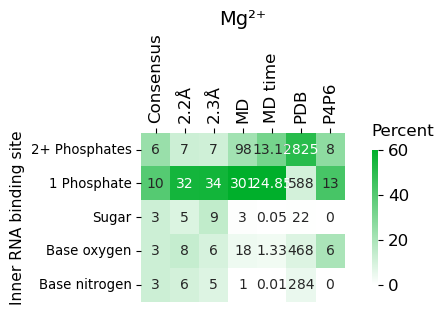

In [16]:
figsizeG = (3.5,2.2)
# plot binding sites
percents = []
counts = []
renamemgrna = {'+2•OP':"2+ Phosphates","OP":"1 Phosphate","Or":"Sugar","Ob":"Base oxygen","Nb":"Base nitrogen"} # '3•OP':"3 Phosphates",
for mgrna in mgrna_inner.keys():
    mgrna_name = renamemgrna[mgrna]
    percent = [mgrna_name,100*matching_22_mg.count(mgrna)/len(matching_22_mg),100*mg22.count(mgrna)/len(mg22),100*mg23.count(mgrna)/len(mg23),100*md_sites_mg_list[mgrna]/md_sites_mg_list.sum(),100*md_sites_mg_list_t[mgrna]/md_sites_mg_list_t.sum(),100*mgrna_inner[mgrna]/total_mg_rna_inner,100*p4p6_mg.count(mgrna)/len(p4p6_mg)]
    count = [mgrna_name,matching_22_mg.count(mgrna),mg22.count(mgrna),mg23.count(mgrna),round(md_sites_mg_list[mgrna],0),round(md_sites_mg_list_t[mgrna],2),mgrna_inner[mgrna],p4p6_mg.count(mgrna)]
    percents.append(percent)
    counts.append(count)
percents = pd.DataFrame(percents,columns=["Inner RNA binding site","Consensus","2.2Å","2.3Å","MD","MD time","PDB","P4P6"]).set_index("Inner RNA binding site")
counts = pd.DataFrame(counts,columns=["Inner RNA binding site","Consensus","2.2Å","2.3Å","MD","MD time","PDB","P4P6"]).set_index("Inner RNA binding site")
# ,"Consensus Mg²⁺","2.2Å Mg²⁺","2.3Å Mg²⁺","MgRNA"
print(percents)
fig, axes = plt.subplots(1,1,figsize=figsizeG)


cmap = LinearSegmentedColormap.from_list("mgocmap", ["white",mg_color])
g=sns.heatmap(data=percents,annot=counts,fmt='g',cmap=cmap,ax=axes,annot_kws={"size": 10},
             vmin=0,vmax=60,cbar_kws={"pad":0.1,"shrink":0.8,"location":"right"})
g.tick_params(axis='y', rotation=0,labelsize=ticksize*0.8)
g.tick_params(axis='x', labelsize=ticksize,rotation=90)
g.yaxis.label.set_size(labelsize*0.8)
g.xaxis.tick_top()
ticks =g.get_xticks()# [g.get_xticks()[0]-0.4]
#ticks.extend(list(g.get_xticks()[1:]))
g.set_xticks(ticks,g.get_xticklabels())
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=ticksize)
cbar.ax.set_title('Percent',size=ticksize,pad=10,loc="left")
cbar.ax.get_yaxis().labelpad = ticksize
#cbar.ax.tick_params(labelsize=ticksize)
#cbar.set_label('Percent',size=ticksize,rotation=270)
#cbar.ax.get_yaxis().labelpad = ticksize
g.set_title("Mg²⁺",size=labelsize)

plt.savefig("interaction_types_summ_Mg.png",dpi=dpi, bbox_inches="tight",transparent=True)
plt.savefig("interaction_types_summ_Mg.svg", bbox_inches="tight",transparent=True)

[]
                                  Consensus       2.2Å       2.3Å         MD  \
Inner RNA binding site                                                         
Phospate                          21.739130  25.855513  30.201342  13.659323   
Sugar                              6.521739   9.505703  10.738255   8.135411   
Base                              21.739130  24.714829  19.798658  25.803332   
Phospate\nSugar                   17.391304  14.448669  15.436242  16.002149   
Phospate\nBase                    13.043478   8.745247   7.718121  16.141859   
Base\nSugar                       17.391304  13.688213  12.416107  14.959699   
Phospate\nBase Sugar               2.173913   2.661597   3.020134   5.169264   
Near carbon or\nphosphorous only   0.000000   0.380228   0.671141   0.128963   

                                    MD time       P4P6  
Inner RNA binding site                                  
Phospate                          60.024206  22.707424  
Sugar                    

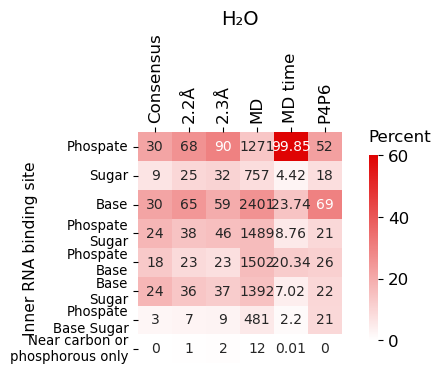

In [17]:
figsizeG = (3.5,3)
percents = []
counts = []
all_water_sites = ['Phospate', 'Sugar', 'Base', 'Phospate\nSugar', 'Phospate\nBase', 'Base\nSugar', 'Phospate\nBase Sugar','Near carbon or\nphosphorous only']
print([f"x,{matching_22_water.count(x)},{wat22.count(x)},{wat23.count(x)}" for x in set(matching_22_water+wat22+wat23) if x not in all_water_sites])
for mgrna in all_water_sites:
    percent = [mgrna,100*matching_22_water.count(mgrna)/len(matching_22_water),100*wat22.count(mgrna)/len(wat22),
               100*wat23.count(mgrna)/len(wat23),100*md_sites_wat_list[mgrna]/md_sites_wat_list.sum(),
               100*md_sites_wat_list_t[mgrna]/md_sites_wat_list_t.sum(),100*p4p6_water.count(mgrna)/len(p4p6_water)]
    count = [mgrna,matching_22_water.count(mgrna),wat22.count(mgrna),wat23.count(mgrna),round(md_sites_wat_list[mgrna],0),round(md_sites_wat_list_t[mgrna],2),p4p6_water.count(mgrna)]
    percents.append(percent)
    counts.append(count)
percents = pd.DataFrame(percents,columns=["Inner RNA binding site","Consensus","2.2Å","2.3Å","MD","MD time","P4P6"]).set_index("Inner RNA binding site")
counts = pd.DataFrame(counts,columns=["Inner RNA binding site","Consensus","2.2Å","2.3Å","MD","MD time","P4P6"]).set_index("Inner RNA binding site")

print(percents)
fig, axes = plt.subplots(1,1,figsize=figsizeG)
cmap = LinearSegmentedColormap.from_list("h2ocmap", ["white",h2o_color])

g=sns.heatmap(data=percents,annot=counts,fmt='g',cmap=cmap,ax=axes,annot_kws={"size": 10},
             vmin=0,vmax=60,cbar_kws={"pad":0.1,"shrink":0.8,"location":"right"})
g.tick_params(axis='y', rotation=0,labelsize=ticksize*0.8)
g.tick_params(axis='x', labelsize=ticksize,rotation=90)
g.set_ylabel(g.get_ylabel(),labelpad=-20,rotation=90,size=labelsize*0.8)
g.xaxis.tick_top()
ticks = g.get_xticks()# [g.get_xticks()[0]-0.4]
#ticks.extend(list(g.get_xticks()[1:]))
g.set_xticks(ticks,g.get_xticklabels())
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=ticksize)
cbar.ax.set_title('Percent',size=ticksize,pad=10,loc="left")
cbar.ax.get_yaxis().labelpad = ticksize
g.set_title("H₂O",size=labelsize)
plt.savefig("interaction_types_summ_wat.png",dpi=dpi, bbox_inches="tight",transparent=True)
plt.savefig("interaction_types_summ_wat.svg", bbox_inches="tight",transparent=True)